<a href="https://colab.research.google.com/github/nhtsai/KITTI-distance-estimation/blob/master/Detectron2_KITTI_Distance_Estimation_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.8.1+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import torch
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
%matplotlib inline

# import inference
from keras.models import model_from_json
from sklearn.preprocessing import StandardScaler

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [14]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("Cityscapes/mask_rcnn_R_50_FPN.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Cityscapes/mask_rcnn_R_50_FPN.yaml")
predictor = DefaultPredictor(cfg)

model_final_af9cf5.pkl: 176MB [00:08, 21.8MB/s]                           


In [119]:
im = cv2.imread("./pinesansome.jpg")
outputs = predictor(im)

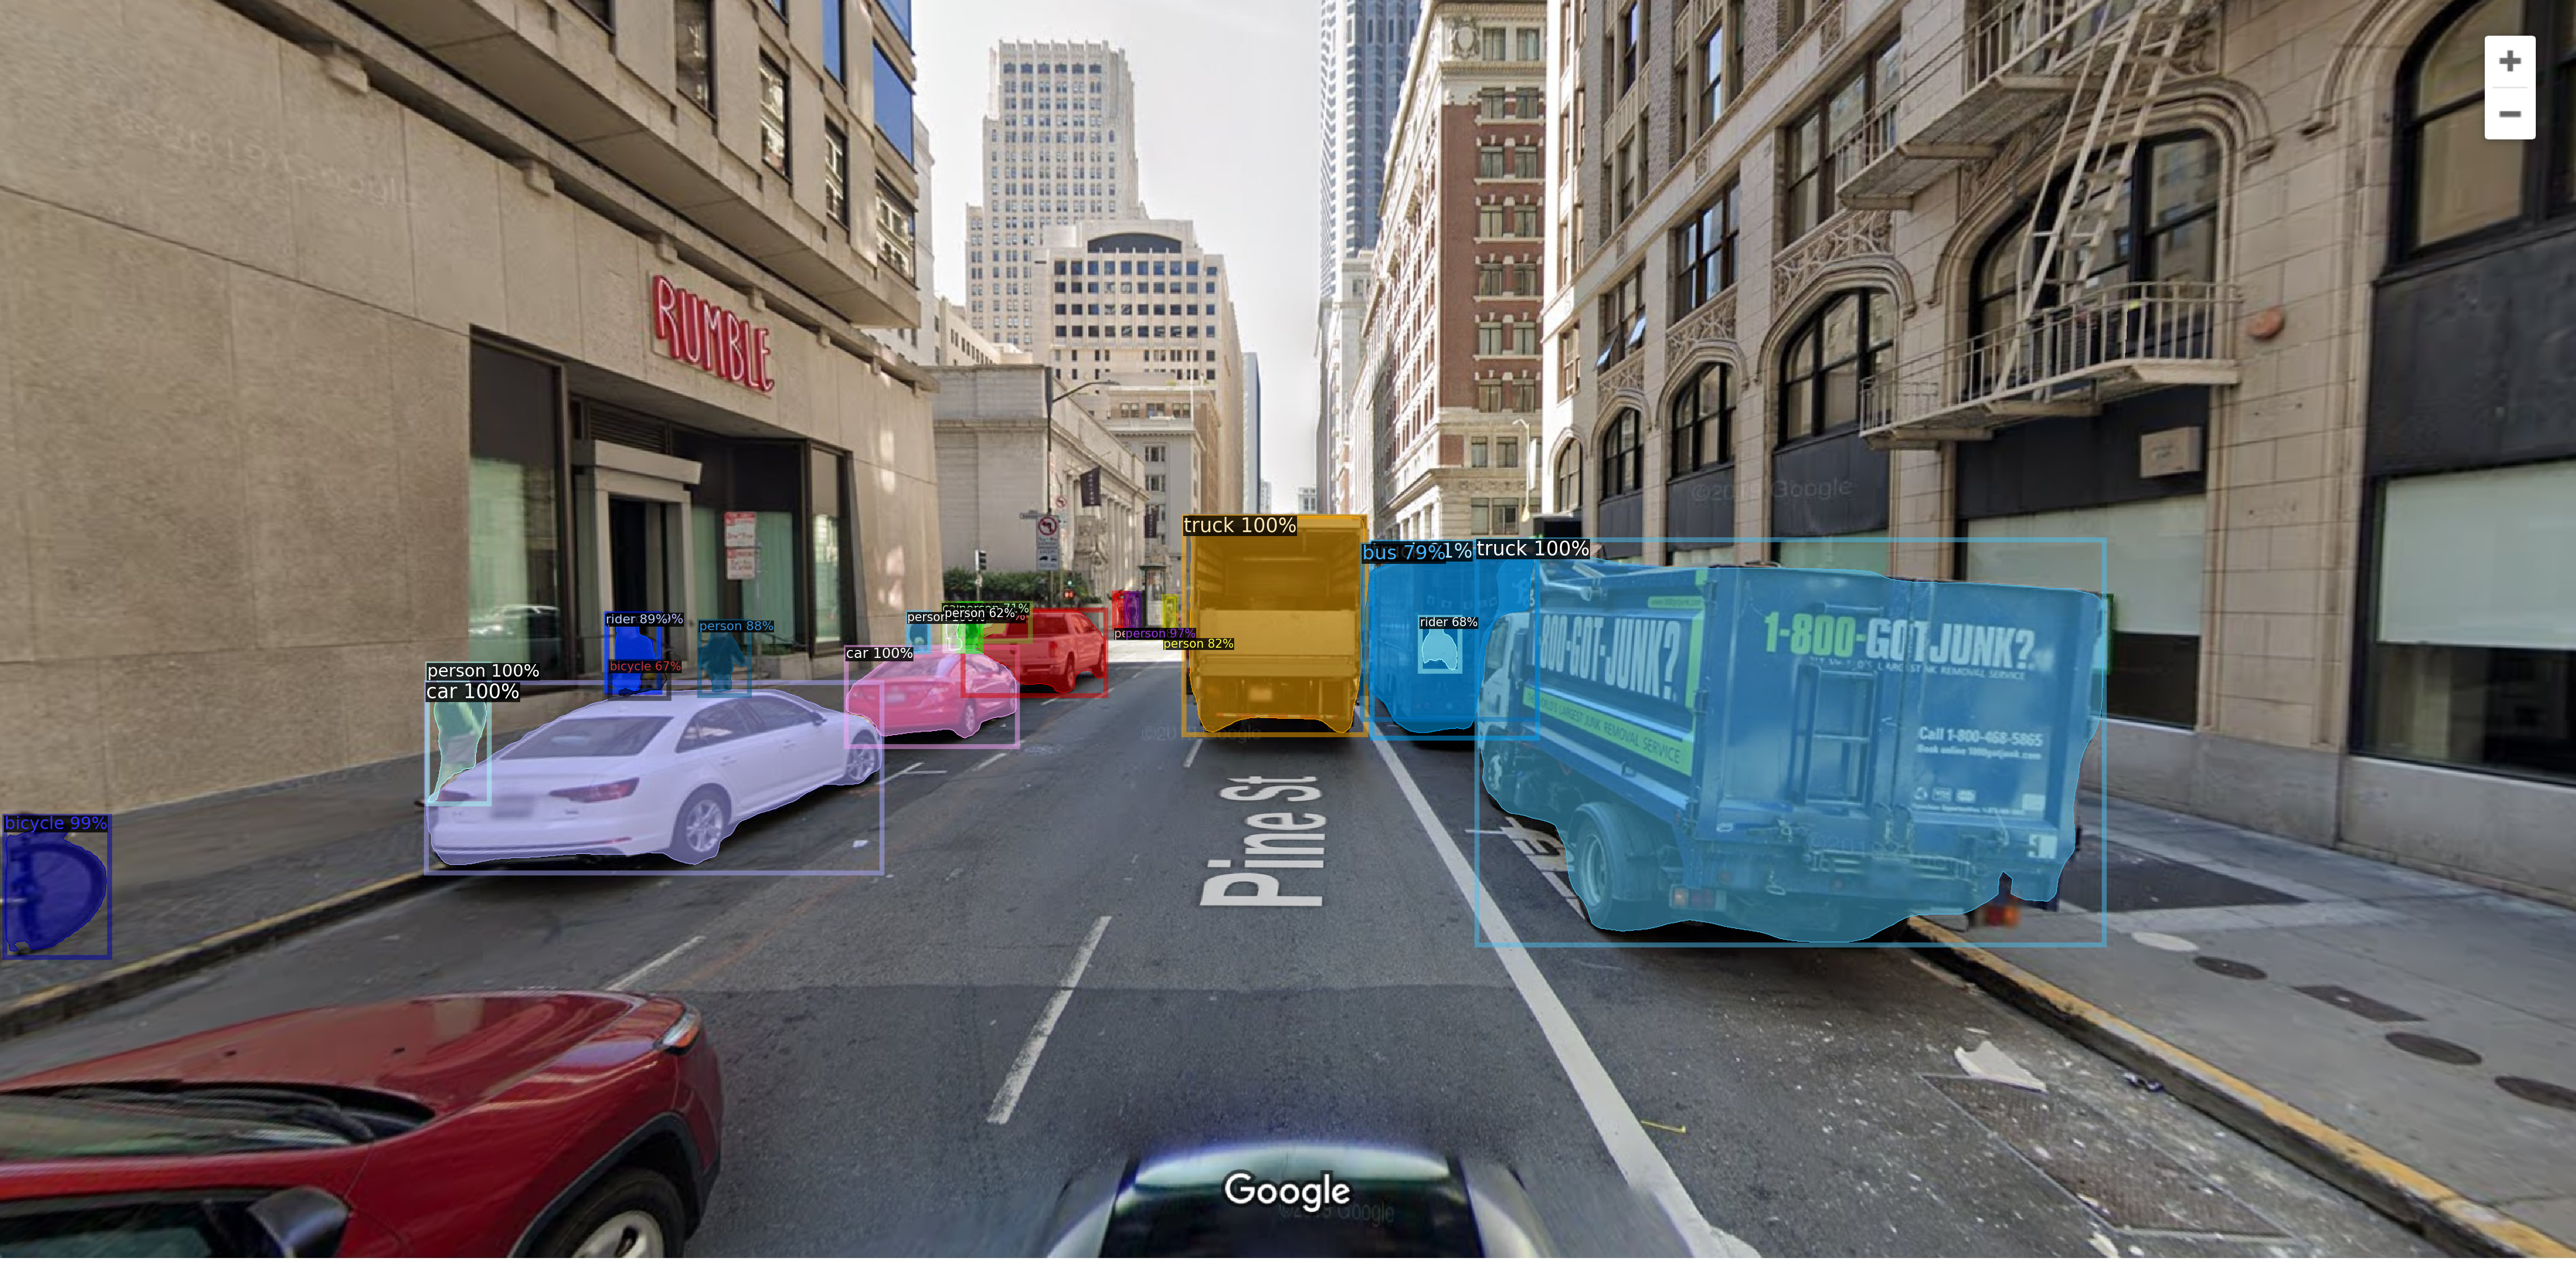

In [120]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

https://github.com/harshilpatel312/KITTI-distance-estimation

In [6]:
!git clone https://github.com/harshilpatel312/KITTI-distance-estimation.git

fatal: destination path 'KITTI-distance-estimation' already exists and is not an empty directory.


In [95]:
MODEL = "model@1535477330.json"
WEIGHTS = "model@1535477330.h5"

In [97]:
# load json and create model
json_file = open("KITTI-distance-estimation/distance-estimator/generated_files/{}".format(MODEL), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json( loaded_model_json )

# load weights into new model
loaded_model.load_weights("KITTI-distance-estimation/distance-estimator/generated_files/{}".format(WEIGHTS))
print("Loaded model from disk")

Loaded model from disk


In [101]:
# get data
# df_test = pd.read_csv('KITTI-distance-estimation/distance-estimator/data/test.csv')
# X_test = df_test[['xmin', 'ymin', 'xmax', 'ymax']].values
y_test = df_test[['zloc']].values

X_test = outputs['instances'].pred_boxes.tensor.cpu().numpy()

# standardized data
scalar = StandardScaler()
X_test_scaled = scalar.fit_transform(X_test)
y_test_scaled = scalar.fit_transform(y_test)

In [102]:
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam')
y_pred = loaded_model.predict(X_test_scaled)

In [103]:
# scale up predictions to original values
y_pred = scalar.inverse_transform(y_pred)
y_test = scalar.inverse_transform(y_test_scaled)

# save predictions
# df_result = df_test
# df_result['zloc_pred'] = -100000

y_pred

array([[ 8.364127 ],
       [18.430977 ],
       [14.892412 ],
       [15.140153 ],
       [ 4.1913977],
       [12.35733  ],
       [36.06564  ],
       [35.228657 ],
       [ 5.2974424],
       [47.66004  ],
       [14.843489 ],
       [24.721558 ],
       [22.379656 ],
       [39.53683  ],
       [15.937958 ],
       [24.147583 ],
       [36.616997 ],
       [28.765562 ],
       [26.892931 ],
       [37.111298 ],
       [47.450478 ]], dtype=float32)

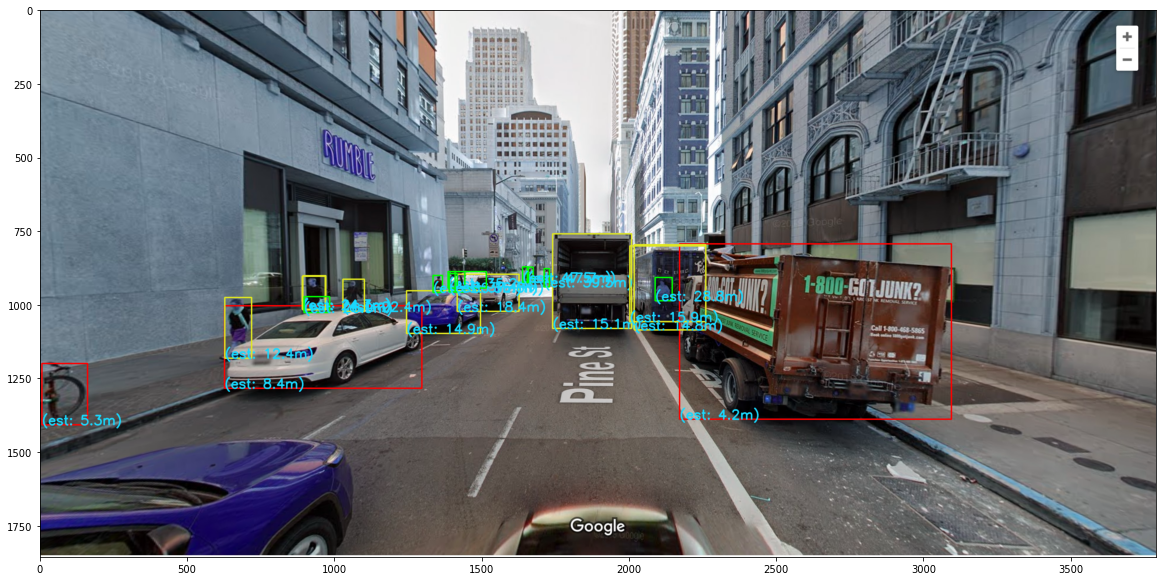

In [131]:
im = cv2.imread("./pinesansome.jpg")

for i, row in enumerate(X_test):
    distance = y_pred[i][0]

    if distance < 10:
        color = (255, 0, 0)
    elif distance < 25:
        color = (224, 231, 34)
    else:
        color = (0, 255, 0)

    # draw bounding box
    x1, y1, x2, y2 = row
    cv2.rectangle(im, (x1, y1), (x2, y2), color, 3)

    # add prediction label
    # brake_dist = brake_distance(v=kmh(speed_in_mph))
    string = "(est: {:.1f}m)".format(distance)
    cv2.putText(im, string, (int(x1), int(y2)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (25, 217, 255), 3, cv2.LINE_AA)
    
fig, ax = plt.subplots(figsize=(20, 12))
ax.imshow(im)
fig.show()